In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')
warnings.filterwarnings('ignore')

### 1. 加载数据集

In [2]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
            
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [47]:
train = pd.read_csv('./data/train.csv')
testA = pd.read_csv('./data/testA.csv')
testA = reduce_mem_usage(testA)
train = reduce_mem_usage(train)

Memory usage of dataframe is 73600128.00 MB
Memory usage after optimization is: 18034520.00 MB
Decreased by 75.5%
Memory usage of dataframe is 300800128.00 MB
Memory usage after optimization is: 72834944.00 MB
Decreased by 75.8%


### 2.简单建模

In [4]:
data = train.drop(['id','issueDate','isDefault'],axis=1)
target = train['isDefault']

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,target,test_size=0.2)

In [6]:
# 安装包需要在scripts的目录下进行安装
import lightgbm as lgb
train_matrix = lgb.Dataset(X_train,label=y_train)
test_matrix = lgb.Dataset(X_test,label=y_test)

In [7]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
#             'silent': True,
            'verbose': -1,
}


"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=test_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[126]	valid_0's auc: 0.71844


### 3.对验证集进行预测

In [31]:
X_test.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
368464,7000.0,3,14.328125,240.375,C,C1,290345.0,3 years,1,29000.0,...,5.0,7.0,7.0,8.0,6.0,10.0,0.0,0.0,0.0,0.0
792658,16992.0,5,24.500000,494.000,F,F3,857.0,7 years,1,56000.0,...,7.0,7.0,11.0,19.0,7.0,12.0,0.0,0.0,0.0,3.0
632583,2500.0,3,10.492188,81.250,B,B2,2017.0,< 1 year,1,33000.0,...,4.0,13.0,7.0,7.0,7.0,18.0,0.0,0.0,0.0,0.0
185340,27008.0,5,19.187500,703.000,E,E3,31873.0,9 years,1,90000.0,...,6.0,2.0,7.0,11.0,6.0,8.0,0.0,0.0,0.0,1.0
577813,6248.0,3,14.312500,214.500,C,C4,1917.0,< 1 year,2,21000.0,...,8.0,2.0,14.0,18.0,6.0,15.0,0.0,0.0,0.0,4.0


lightbgm模型在测试集上的auc0.7167105366761097


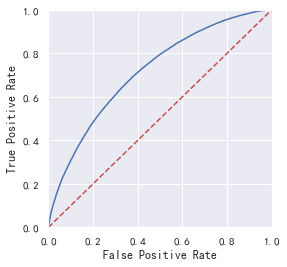

In [60]:
# 对模型的评估
from sklearn import metrics
from sklearn.metrics import roc_auc_score

y_predict = model.predict(X_test,num_iteration=model.best_iteration)
# 绘制roc曲线 
fpr,tpr,threshold = metrics.roc_curve(y_test,y_predict)
roc_auc = metrics.auc(fpr,tpr)
print('lightbgm模型在测试集上的auc{}'.format(roc_auc))
""" 绘制roc曲线"""

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr,'b',label = 'Val AUC = %0.4f'%roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1],'r--')
plt.show()

In [63]:
y_test

368464    0
792658    0
632583    1
185340    1
577813    1
         ..
154710    1
621355    1
671091    1
114185    0
30310     0
Name: isDefault, Length: 160000, dtype: int8

In [62]:
y_predict

[0.17241074 0.54411535 0.14286142 ... 0.37675433 0.18724987 0.0491126 ]


### 4.模型调参

In [9]:
# k折交叉验证
folds = 5
seed =2020
kf = KFold(n_splits=folds,shuffle=True,random_state=seed)

<IPython.core.display.Javascript object>

In [10]:
# 手动实现5折交叉验证
cv_scores = []

for i,(train_index,test_index) in enumerate(kf.split(X_train,y_train)):
    print('***************{}***************'.format(str(i+1)))
    X_train_split,y_train_split,X_val,y_val = X_train.iloc[train_index],y_train.iloc[train_index],X_train.iloc[test_index],y_train.iloc[test_index]
    
    train_matrix = lgb.Dataset(X_train_split,label=y_train_split)
    valid_matrix = lgb.Dataset(X_val,label=y_val)
    
    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

***************1***************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.715512
[0.7155121008953185]
***************2***************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.720066
[0.7155121008953185, 0.7200662390784149]
***************3***************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.714488
[0.7155121008953185, 0.7200662390784149, 0.7144881514123413]
***************4***************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	valid_0's auc: 0.717404
[0.7155121008953185, 0.7200662390784149, 0.714488151412

In [ ]:
## 使用简洁式网格搜索
from sklearn.model_selection import GridSearchCV
param_grid ={
    
}

cv = GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,verbose=0)




In [48]:
"""通过网格搜索确定最优参数"""
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [49]:
get_best_cv_params()

<IPython.core.display.Javascript object>

TypeError: 'NoneType' object is not iterable

### 5. 结果集预测

In [58]:
# 结果集预测
columns = X_test.columns.tolist()
data_testA = testA[columns]
y_testA = model.predict(data_testA,num_iteration=model.best_iteration)

In [59]:
# 导出结果集
result = testA[['id']]
result['isDefault'] = y_testA
result.head()

,id,isDefault
0,800000,0.087073
1,800001,0.305158
2,800002,0.461331
3,800003,0.266640
4,800004,0.392486


In [69]:
# 这个地方使用lambda函数
result['isDefault'] = result['isDefault'].apply(lambda x:1 if x>=0.5 else 0)

In [72]:
is_default = result['isDefault'].value_counts()

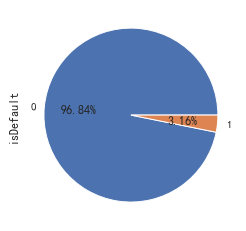

In [74]:
is_default.plot(kind = 'pie',autopct = "%0.2f%%")

In [76]:
result.to_csv('./data/result_平台项目.csv')